In [1]:
import json
import sys
import os
import numpy as np
import skimage
from scipy import ndimage
from scipy import special
from scipy import sparse
import anndata
import nibabel as nib
import pandas as pd
import datashader as ds
import time
from sklearn.decomposition import PCA
import collections
import pickle as pkl
import zarr
import h5py
import anndata as ad

import ants
import nibabel as nib

from dredFISH.Analysis.__init__plots import *
sns.set_style('white')

from dredFISH.Analysis import basicu

# sys.path.insert(0, '/home/fangming/projects/dredfish/packages/PySpots')
from MERFISH_Objects.FISHData import *

from dredFISH.Analysis import powerplots

# Load data

In [2]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + "figures/"

In [3]:
f = f'{dat_dir}/rna/smrt_nn_v1_April26.h5ad'
adata = anndata.read(f)

f = f'{dat_dir}/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
adata0 = anndata.read(f)

In [4]:
# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)

In [5]:
def plot_celltype_heatmap(Xmat, splitat, splitat_v, title='scRNA-seq'):
    """
    """
    # plot 
    fig, ax = plt.subplots(1, 1, figsize=(6, 10))
    cbar_ax = fig.add_axes([.97, .4, .01, .2])
    
    Xmat = Xmat.fillna(0)
    sns.heatmap(Xmat, 
                yticklabels=True, xticklabels=True, 
                vmax=3, vmin=-3, cmap='coolwarm', 
                cbar_ax=cbar_ax,
                cbar_kws=dict(label='normed features'),
                ax=ax)
    ax.set_title(f'{title}')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)
    # lines
    ax.hlines(1+np.array(splitat), 0, Xmat.shape[1], linewidth=0.5, color='gray')
    ax.vlines(1+np.array(splitat_v), 0, Xmat.shape[0], linewidth=0.5, color='gray')
    return


In [6]:
# predicted labels???
level = 'subclass_label'
row_order = meta['l3_clsts']
col_order = np.arange(24)# meta['l3_bits']

# cluster mean reference
# refdata (X)
Xclst, _ = basicu.group_mean(
    adata.X, 
    adata.obs[level].values, 
    row_order)
Xclst = basicu.zscore(Xclst, allow_nan=True, axis=0)
Xclst = Xclst[:,col_order]
Xclst = pd.DataFrame(Xclst, index=row_order, columns=col_order)

In [7]:
# predicted labels???
level = 'subclass_label'
row_order = meta['l3_clsts']
col_order = meta['l3_bits']

# cluster mean reference
# refdata (X)
Xclst0, _ = basicu.group_mean(
    adata0.X, 
    adata0.obs[level].values, 
    row_order)
Xclst0 = basicu.zscore(Xclst0, allow_nan=True, axis=0)
Xclst0 = Xclst0[:,col_order]
Xclst0 = pd.DataFrame(Xclst0, index=row_order, columns=col_order)

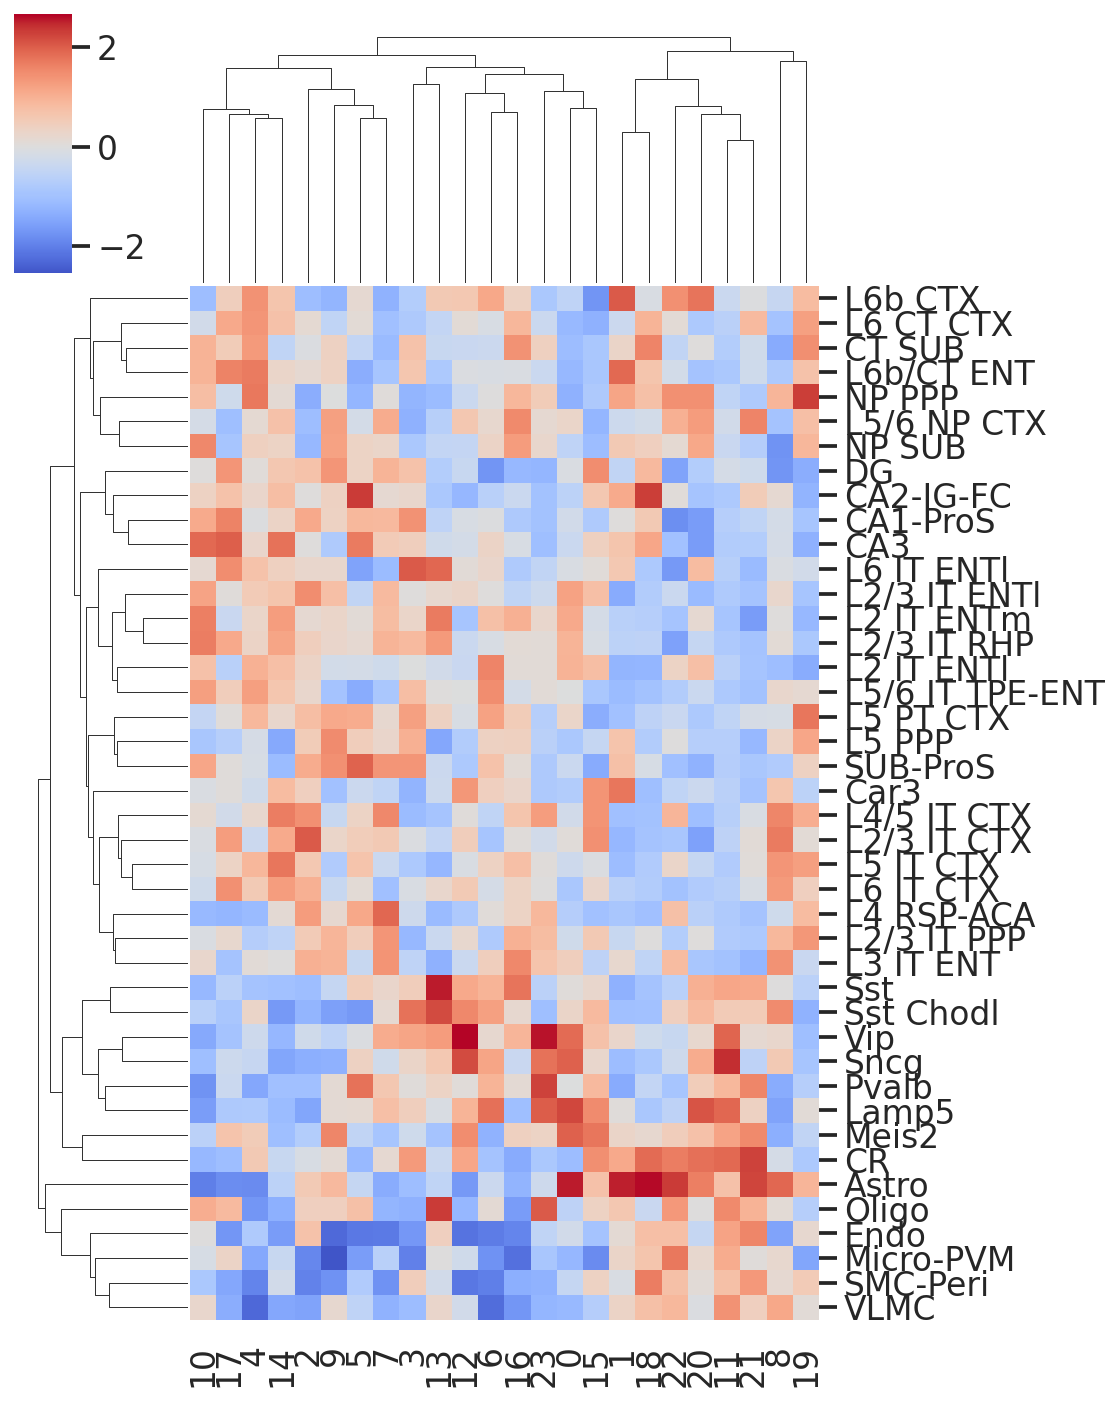

In [8]:
g = sns.clustermap(Xclst, center=0, 
                   xticklabels=True,
                   yticklabels=True,
                   cmap='coolwarm', 
                   figsize=(8,10),
                  )

In [9]:
Xclst.max().max(), Xclst.min().min(), Xclst0.max().max(), Xclst0.min().min()

(2.6632279925660867,
 -2.5526477644125056,
 6.333193912161196,
 -2.8022430702399994)

saved the figure to: /bigstore/GeneralStorage/fangming/projects/dredfish/figures/nn_projected_mat_2022-05-11.pdf


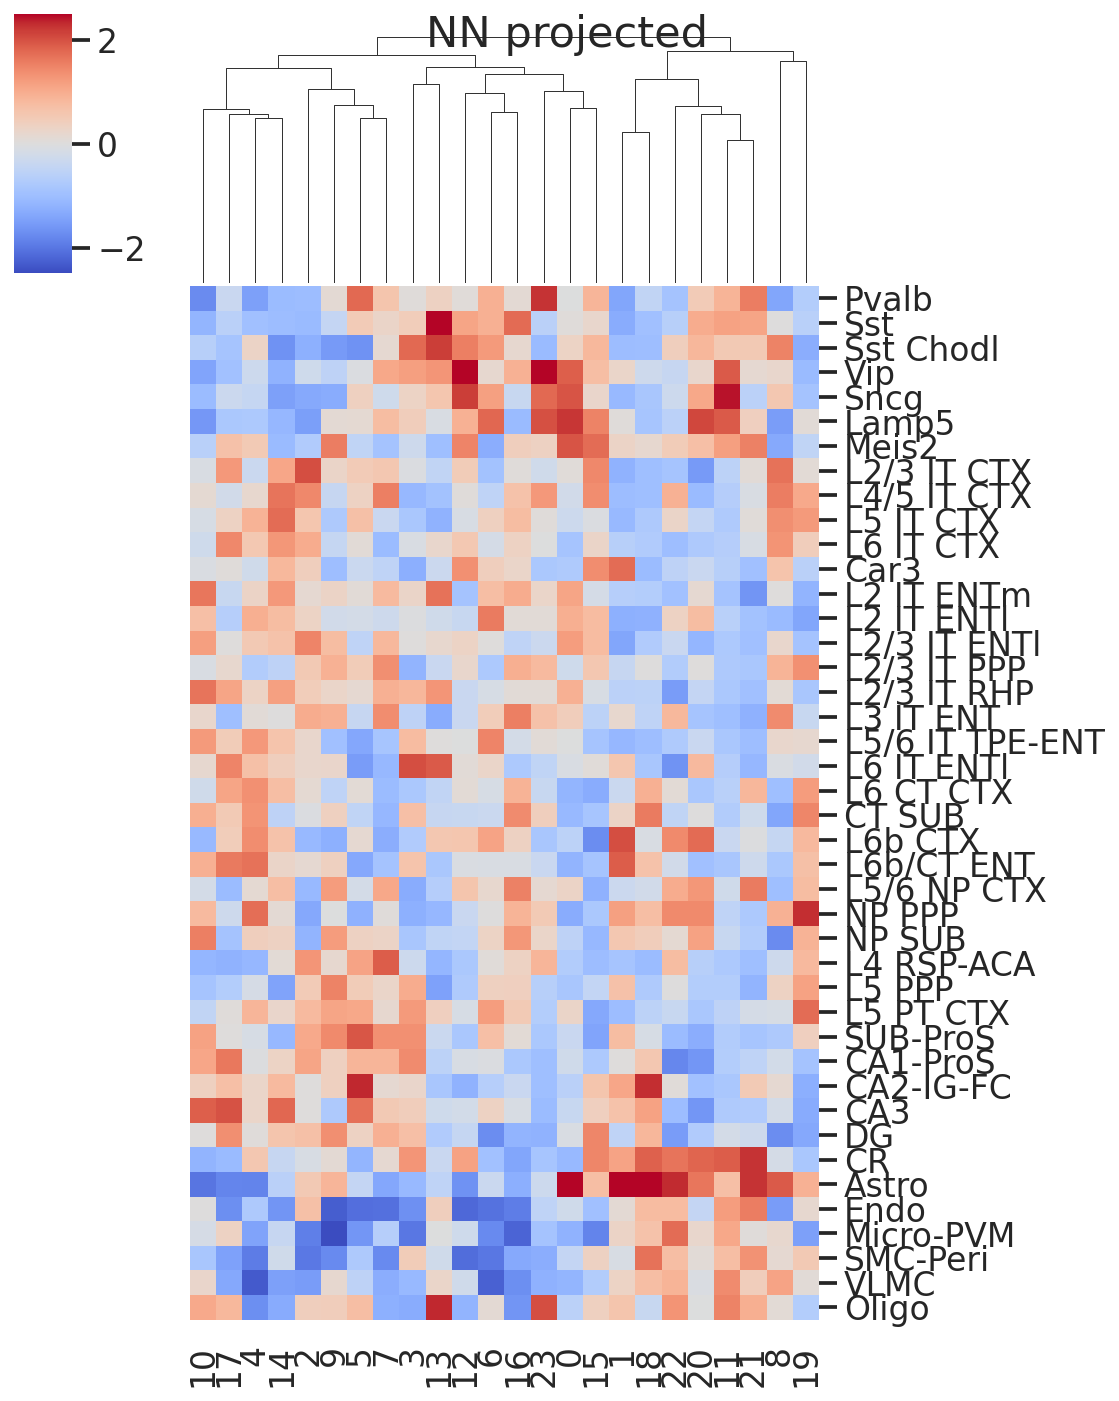

In [10]:
g = sns.clustermap(Xclst, center=0, 
                   row_cluster=False,
                   xticklabels=True,
                   yticklabels=True,
                   cmap='coolwarm', 
                   figsize=(8,10),
                   vmax=2.5, vmin=-2.5,
                  )
g.fig.suptitle('NN projected')
powerplots.savefig_autodate(g.fig, os.path.join(fig_dir, "nn_projected_mat.pdf"))

saved the figure to: /bigstore/GeneralStorage/fangming/projects/dredfish/figures/dpnmf_projected_mat_2022-05-11.pdf


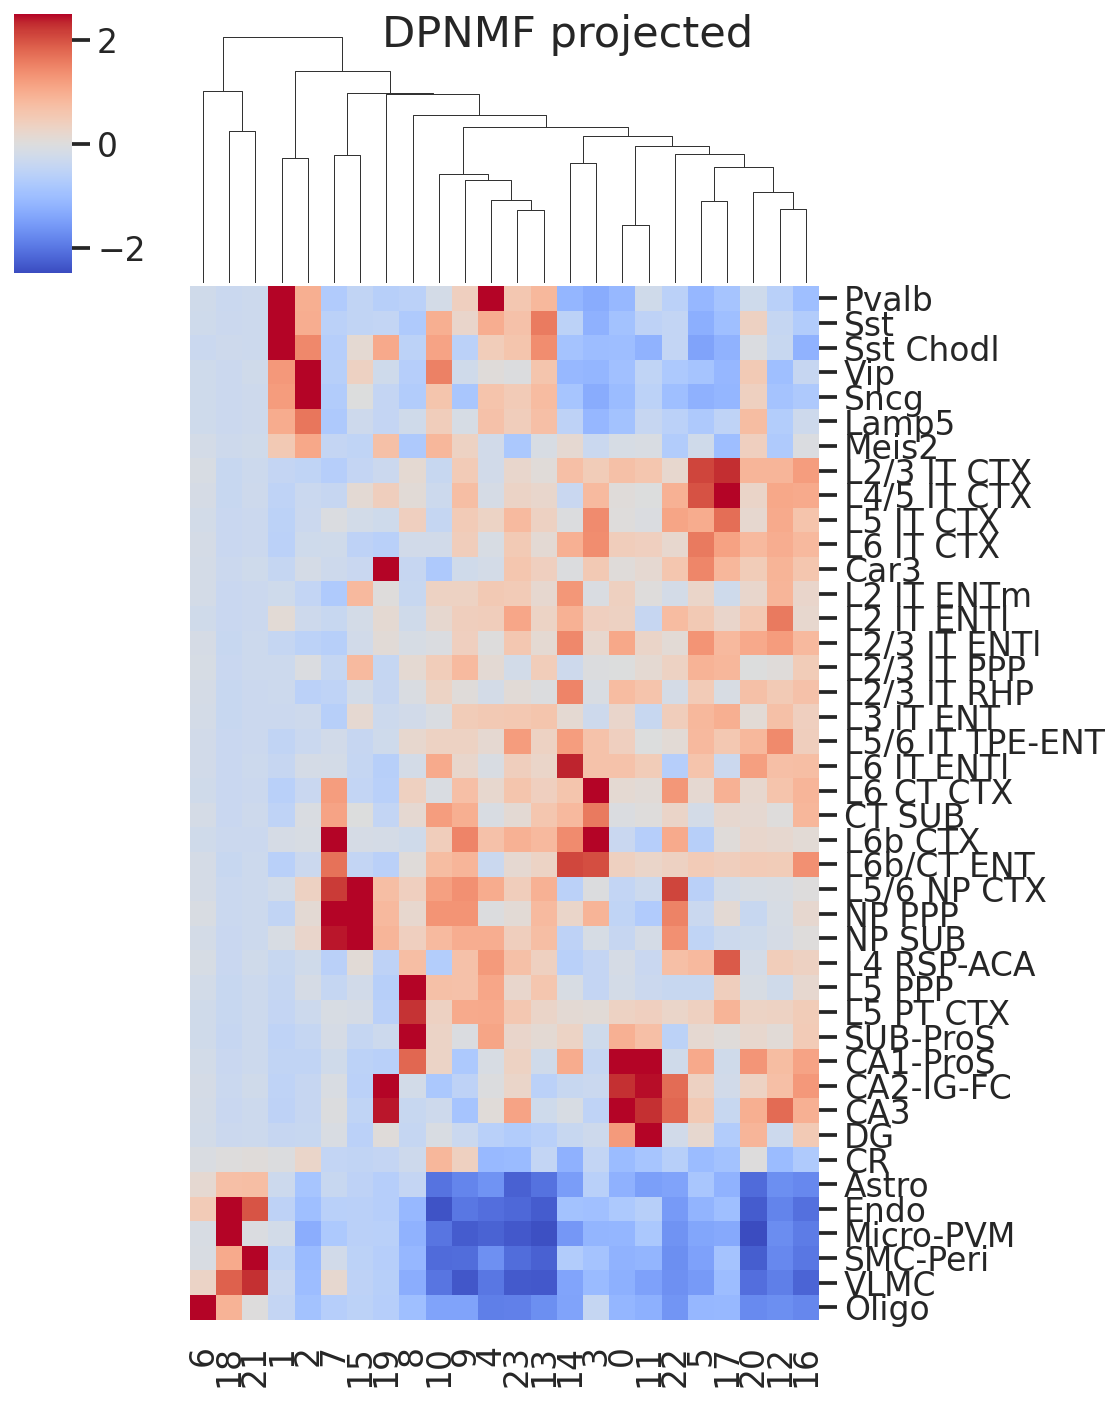

In [11]:
g = sns.clustermap(Xclst0, center=0, 
                   row_cluster=False,
                   xticklabels=True,
                   yticklabels=True,
                   cmap='coolwarm', 
                   figsize=(8,10),
                   vmax=2.5, vmin=-2.5,
                  )
g.fig.suptitle('DPNMF projected')
powerplots.savefig_autodate(g.fig, os.path.join(fig_dir, "dpnmf_projected_mat.pdf"))

In [12]:
# dir(g)

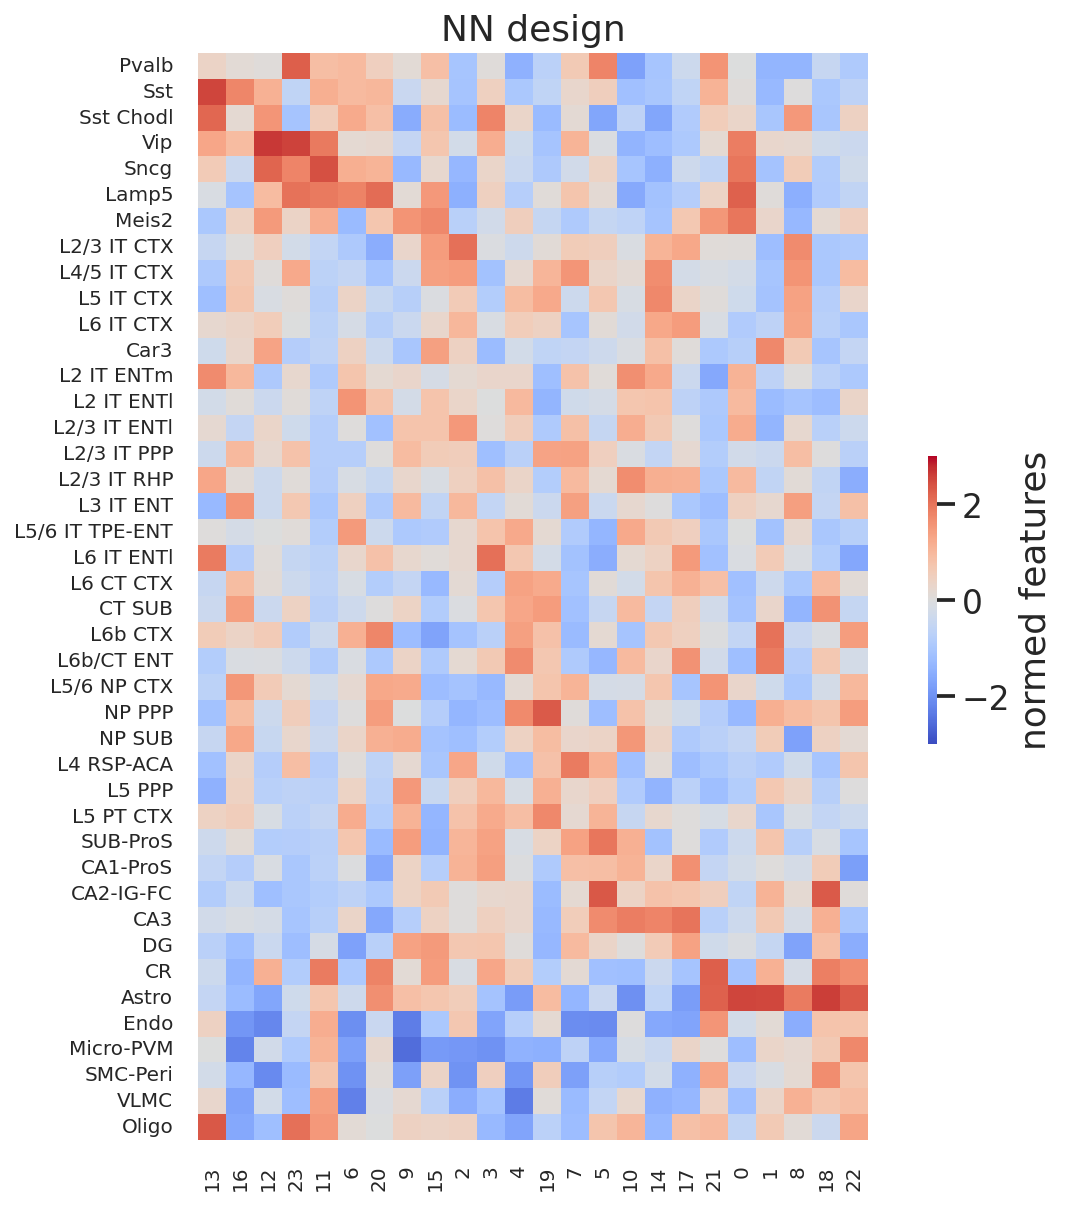

In [13]:
# XclstP, rows, cols = basicu.diag_matrix_rows(
#                        Xclst.values, 
#                        Xclst.index.values, 
#                        Xclst.columns.values,
#                         )
# XclstP = pd.DataFrame(XclstP, index=rows, columns=cols)

XclstPt, cols, rows = basicu.diag_matrix_rows(
                       Xclst.values.T, 
                        )
XclstP = pd.DataFrame(XclstPt.T, 
                      index=Xclst.index.values[rows], 
                      columns=Xclst.columns.values[cols],
                     )

plot_celltype_heatmap(XclstP, 
                      [],
                      [],
                      'NN design',
                      )

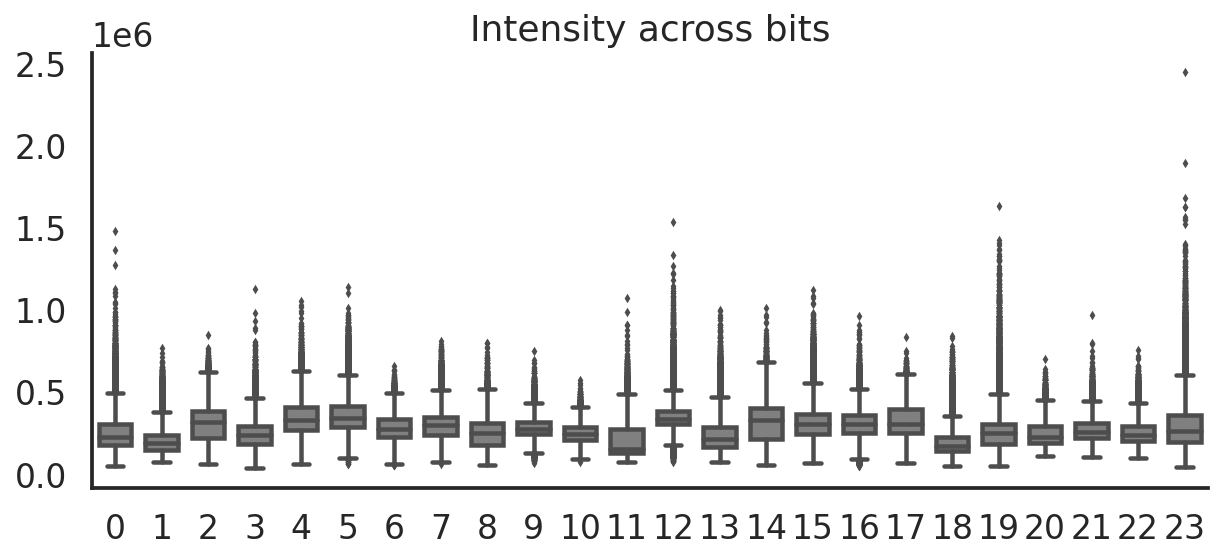

In [14]:
# intensity across bits
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=adata.X, ax=ax, color='gray', fliersize=2, width=0.7)
ax.set_title('Intensity across bits')
sns.despine(ax=ax)
plt.show()

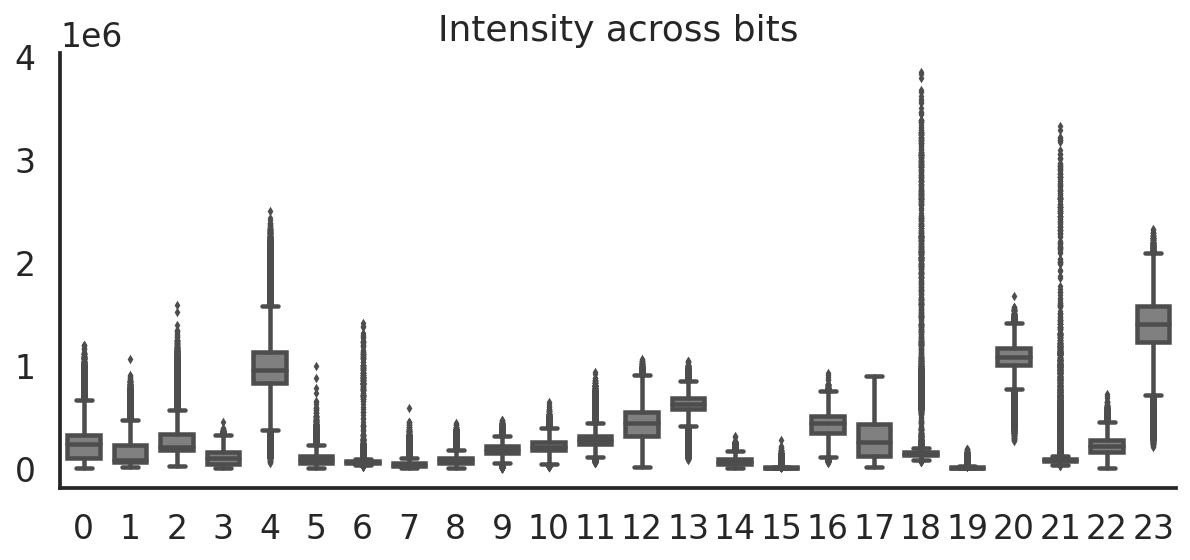

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=adata0.X, ax=ax, color='gray', fliersize=2, width=0.7)
ax.set_title('Intensity across bits')
sns.despine(ax=ax)
plt.show()

saved the figure to: /bigstore/GeneralStorage/fangming/projects/dredfish/figures/prjmat_compared_med_intnsty_2022-05-11.pdf


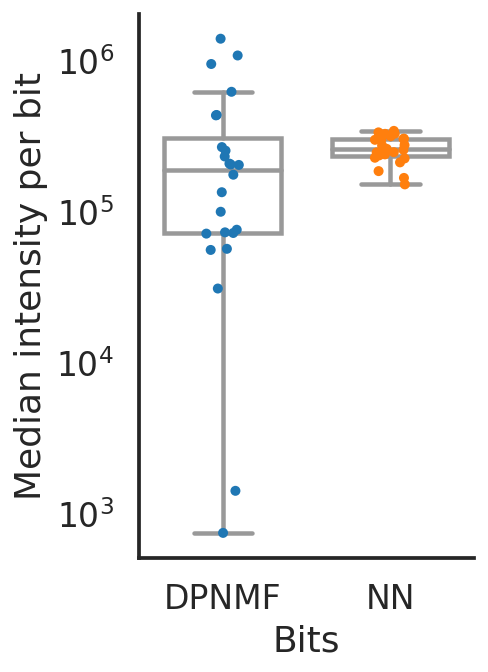

In [16]:
# number of probes
y0 = np.median(adata0.X, axis=0)
y = np.median(adata.X, axis=0)
x = np.arange(24)
_df = pd.DataFrame(np.vstack([y0, y]).T, index=x, columns=['DPNMF', 'NN'])

fig, ax = plt.subplots(figsize=(3,5))
sns.boxplot(data=_df, width=0.7, color='white', fliersize=0, ax=ax)
sns.stripplot(data=_df, ax=ax)
sns.despine(ax=ax)
ax.set_ylabel('Median intensity per bit')
ax.set_xlabel('Bits')
ax.set_yscale('log')
powerplots.savefig_autodate(fig, os.path.join(fig_dir, "prjmat_compared_med_intnsty.pdf"))
plt.show()

saved the figure to: /bigstore/GeneralStorage/fangming/projects/dredfish/figures/NN_DPNMF_intensity_lineplot_2022-05-11.pdf


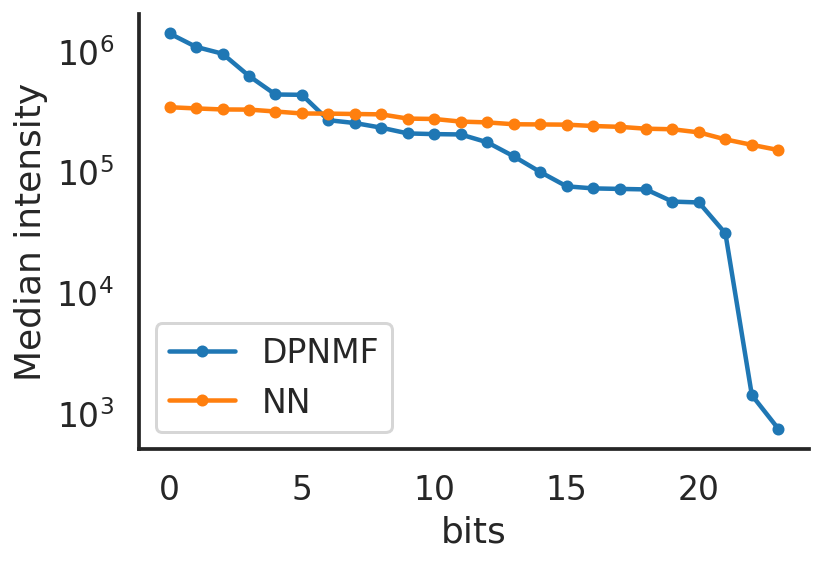

In [17]:
fig, ax = plt.subplots()
ax.plot(np.sort(y0)[::-1], '-o', markersize=5, label='DPNMF')
ax.plot(np.sort(y)[::-1], '-o', markersize=5, label='NN')

# ax.step(np.arange(len(y0)), np.sort(y0)[::-1], where='post', label='DPNMF')
# ax.step(np.arange(len(y)), np.sort(y)[::-1], label='NN')

# ax.bar(np.arange(len(y0)), np.sort(y0)[::-1], label='DPNMF')
# ax.bar(np.arange(len(y)), np.sort(y)[::-1], label='NN')

ax.set_xlabel('bits')
ax.set_ylabel('Median intensity')
sns.despine(ax=ax)
ax.grid(False)
ax.set_yscale('log')
ax.legend()
powerplots.savefig_autodate(fig, os.path.join(fig_dir, "NN_DPNMF_intensity_lineplot.pdf"))
plt.show()

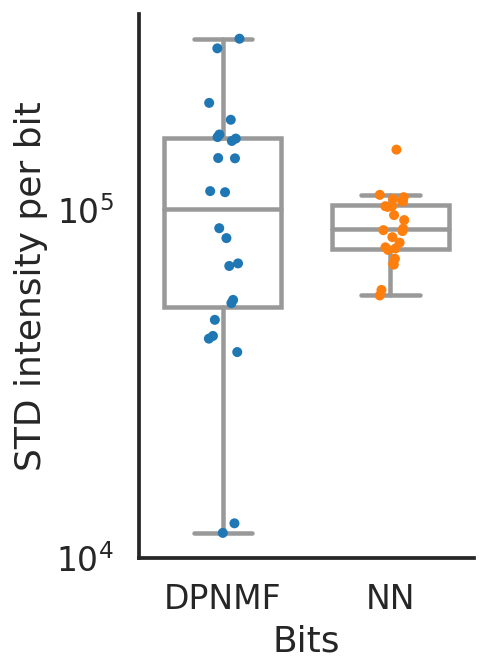

In [18]:
# number of probes
y0 = np.std(adata0.X, axis=0)
y = np.std(adata.X, axis=0)
x = np.arange(24)
_df = pd.DataFrame(np.vstack([y0, y]).T, index=x, columns=['DPNMF', 'NN'])

fig, ax = plt.subplots(figsize=(3,5))
sns.boxplot(data=_df, width=0.7, color='white', fliersize=0, ax=ax)
sns.stripplot(data=_df, ax=ax)
sns.despine(ax=ax)
ax.set_ylabel('STD intensity per bit')
ax.set_xlabel('Bits')
ax.set_yscale('log')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, "prjmat_compared_med_intnsty.pdf"))
plt.show()

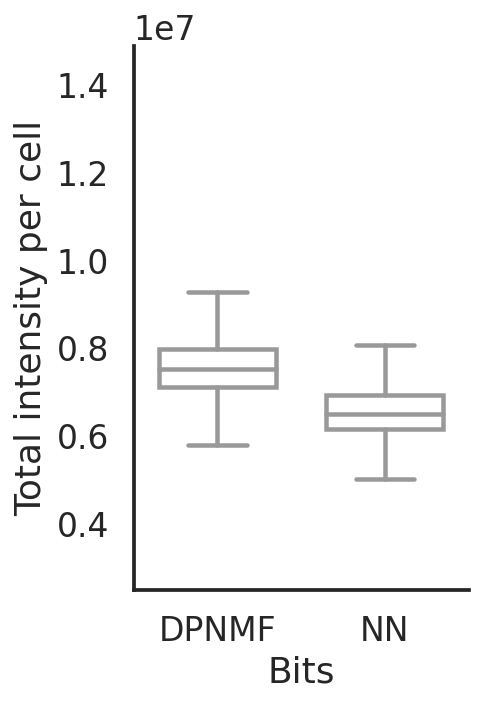

In [19]:
# number of probes
y0 = np.sum(adata0.X, axis=1)
y = np.sum(adata.X, axis=1)
# x = np.arange(24)
_df = pd.DataFrame(np.vstack([y0, y]).T, columns=['DPNMF', 'NN'])

fig, ax = plt.subplots(figsize=(3,5))
sns.boxplot(data=_df, width=0.7, color='white', fliersize=0, ax=ax)
# sns.stripplot(data=_df, ax=ax)
sns.despine(ax=ax)
ax.set_ylabel('Total intensity per cell')
ax.set_xlabel('Bits')
# ax.set_yscale('log')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, "encmat_compared_topgene.pdf"))
plt.show()

In [20]:
corr0 = np.corrcoef(Xclst0)
corrNN = np.corrcoef(XclstP)

saved the figure to: /bigstore/GeneralStorage/fangming/projects/dredfish/figures/NN_DPNMF_correlation_matrix_2022-05-11.pdf


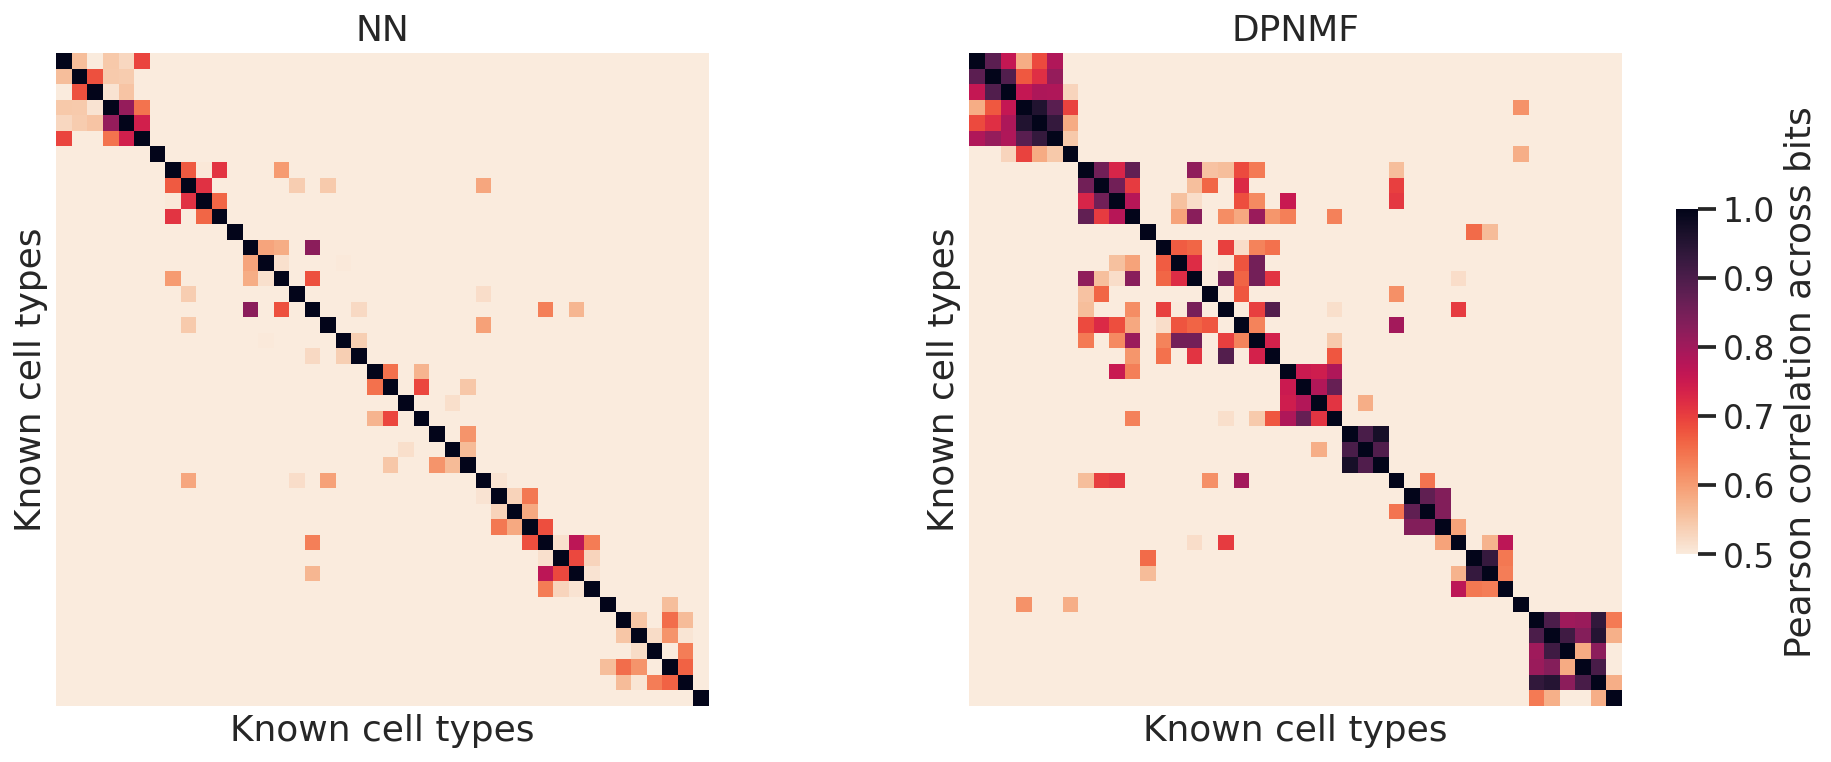

In [21]:

vmin = 0.5

fig, axs = plt.subplots(1,2,figsize=(15, 6))
cbar_ax = fig.add_axes([0.9, 0.3, 0.01, 0.4])
ax = axs[0]
sns.heatmap(corrNN, 
            xticklabels=False, 
            yticklabels=False, 
            cbar_ax=cbar_ax,
            cbar_kws=dict(label='Pearson correlation across bits', 
                          # ticks=[0.5, 0.75, 1],
                         ),
            cmap='rocket_r',
            ax=ax, 
            vmin=vmin,
           )
ax.set_xlabel('Known cell types')
ax.set_ylabel('Known cell types')
ax.set_aspect('equal')
ax.set_title('NN')

ax = axs[1]
sns.heatmap(corr0, 
            xticklabels=False, 
            yticklabels=False, 
            cbar_ax=cbar_ax,
            cbar_kws=dict(label='Pearson correlation across bits', 
                          # ticks=[0.5, 0.75, 1],
                         ),
            cmap='rocket_r',
            ax=ax, 
            vmin=vmin,
           )
ax.set_xlabel('Known cell types')
ax.set_ylabel('Known cell types')
ax.set_aspect('equal')
ax.set_title('DPNMF')

powerplots.savefig_autodate(fig, os.path.join(fig_dir, "NN_DPNMF_correlation_matrix.pdf"))
plt.show()